In [1]:
import pymc3 as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\Users\trann\anaconda3\envs\ppp3\lib\site-packages\theano\configdefaults.py:697: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  "DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
n_applicants = 100
n_booked = 18

In [3]:
with pm.Model() as model:

    # Prior for booking rate (p)
    p = pm.Beta("p", alpha=1, beta=1)  # Uninformative Beta(1,1)

    # Likelihood: number of bookings observed
    bookings = pm.Binomial("bookings",
                           n=n_applicants,
                           p=p,
                           observed=n_booked)

    # Posterior sampling (MCMC with NUTS)
    # return_inferencedata=True --> ensures we get an ArviZ InferenceData object
    idata = pm.sample(
        draws=2000,
        tune=1000,
        target_accept=0.95,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


In [4]:
print(az.summary(idata, var_names=["p"]))

    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
p  0.185  0.038   0.117    0.258      0.001    0.001    2887.0  2887.0   

   ess_bulk  ess_tail  r_hat  
p    2837.0    2971.0    1.0  


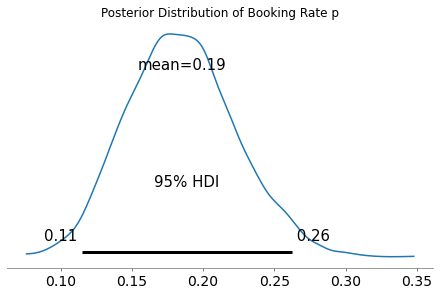

In [5]:
az.plot_posterior(idata, var_names=["p"], hdi_prob=0.95)
plt.title("Posterior Distribution of Booking Rate p")
plt.show()

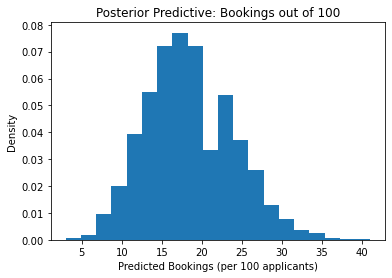

In [6]:
with model:
    ppc = pm.sample_posterior_predictive(idata)

pred_book = ppc["bookings"]  # predicted bookings out of 100

plt.hist(pred_book, bins=20, density=True)
plt.xlabel("Predicted Bookings (per 100 applicants)")
plt.ylabel("Density")
plt.title("Posterior Predictive: Bookings out of 100")
plt.show()

In [7]:
posterior_p = idata.posterior["p"].values.flatten()

expected_bookings_10k = posterior_p * 10_000

print("Posterior mean bookings per 10k applicants:",
      expected_bookings_10k.mean())

print("95% credible interval:",
      np.percentile(expected_bookings_10k, [2.5, 97.5]))

print("Expected bookings per 10k applicants (posterior mean):", 
      expected_bookings_10k.mean())

print("95% credible interval:",
      np.percentile(expected_bookings_10k, [2.5, 97.5]))

Posterior mean bookings per 10k applicants: 1850.2668459025078
95% credible interval: [1160.37745504 2637.85977689]
Expected bookings per 10k applicants (posterior mean): 1850.2668459025078
95% credible interval: [1160.37745504 2637.85977689]
